In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO, Qplate
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
from pyPSFstack.diversities.pola_diversities import PDiversity_QWP, \
    PDiversity_LP, PDiversity_Compound
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring import ExactBlurring

from pyPSFstack_torch.psf_modules import torchPSFStack
from pyPSFstack_torch.pupils.sources import torchDipoleInterfaceSource
from pyPSFstack_torch.pupils.windows import torchSEO
from pyPSFstack_torch.pupils.aberrations import torchUnitaryAberrations
from pyPSFstack_torch.diversities.pupil_diversities import torchZDiversity
from pyPSFstack_torch.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from pyPSFstack_torch.cost_functions import loss_loglikelihood, loss_sumsquared
from pyPSFstack_torch.functions import get_pupils_param_dict, get_normNbck

device = 'cuda' if torch.cuda.is_available() else 'cpu'

plt.rcParams.update({"figure.facecolor" : "white"})

# Numerical experiments for characterizing a birefringent window from a PSF stack

## 1. Parameter definition for the creation of simulated data

In [3]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 10
wavelength = 525
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; zf = 500; z_step = 100
z_list = np.arange(zi,zf+z_step,z_step)
# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)

We put all the parameters in a dictionary 

In [4]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = radius/wavelength

params['qplate'] = {}
params['qplate']['q'] = 1/2

params['seo'] = {}
params['seo']['c'] = 1.25*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,8)[1:-1] 

params['aberrations'] = {}
params['aberrations']['jmax_list'] = [15]*4+[15]

Instantiate all the class elements need to define a PSF stack

In [5]:
# The source and window define th epupil sequence
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
qplate = Qplate(**params['pupil'],**params['qplate'])
seo = SEO(**params['pupil'],**params['seo'])
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
qwp = PDiversity_QWP(angle_list)
wollaston = PDiversity_LP([0, np.pi/2])
pdiv = PDiversity_Compound([qwp, wollaston])
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

## 2. SEO

### 2.1 With polarization diversity

Compute the modelled PSF stack

In [6]:
psfs = PSFStack([src, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

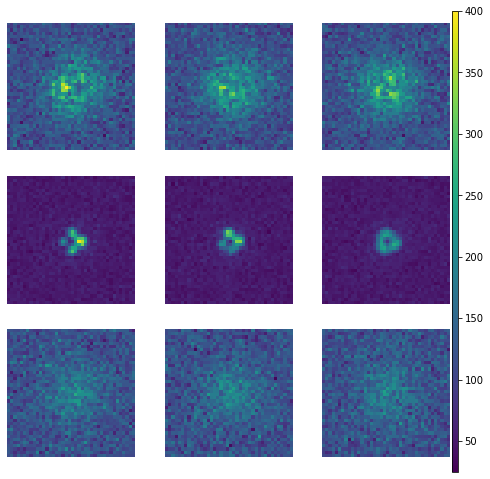

In [7]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
v_max = np.max(data_stack)
v_min = np.min(data_stack)

zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(data_stack[...,0,ind],vmin=v_min,vmax=v_max/3)
    im = axs[1,ind].imshow(data_stack[...,zdiv_mid_ind,ind],vmin=v_min,vmax=v_max)
    axs[2,ind].imshow(data_stack[...,-1,ind],vmin=v_min,vmax=v_max/3)
for ax in axs.ravel():
    ax.set_axis_off()

cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

Define model

In [17]:
tsrc = torchDipoleInterfaceSource(**params['pupil'],**params['source'])
twdw = torchUnitaryAberrations(**params['pupil'], **params['aberrations'])
tpupil_sequence = [tsrc, twdw]
tzdiv = torchZDiversity(**params['zdiversity'], **params['pupil'])
tpdiv = torchPDiversity_Compound([torchPDiversity_QWP(angle_list), 
    torchPDiversity_LP([0, np.pi/2])])

model_retrieved = torchPSFStack(
                 data_stack.shape[0],
                 tpupil_sequence,
                 zdiversity=tzdiv,
                 pdiversity=tpdiv
                 )

We estimate the scaling factor between the data and model and the background

In [18]:
data_norm, data_bck = get_normNbck(data_stack)
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()
model_retrieved.set_scale_factor(data_norm/torch.sum(first_est))
model_retrieved.set_pb_bck(data_bck, opt_b=True)
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()

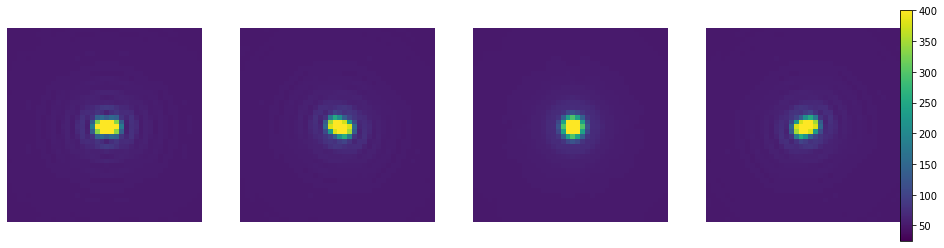

In [19]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
for ind in range(4):
    im =ax[ind].imshow(first_est[...,5,ind],vmin=v_min,vmax=v_max/1)
    ax[ind].set_axis_off()
cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

### 2.2 Define optimization parameters

In [20]:
lr = 3e-2#3e-2 # learning rate
n_epochs = 200

loss_fn = loss_loglikelihood#nn.MSELoss(reduction='mean')#

optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
data = torch.from_numpy(data_stack).type(torch.float)

In [21]:
loss_evol =[]
for epoch in tqdm(range(n_epochs)):
    
    model_retrieved.train()
    yhat = model_retrieved()
    
    loss = loss_fn(yhat, data)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


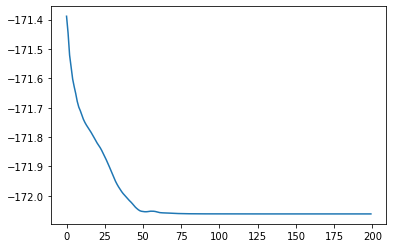

In [23]:
plt.plot(loss_evol)
# plt.gca().set_yscale('log')

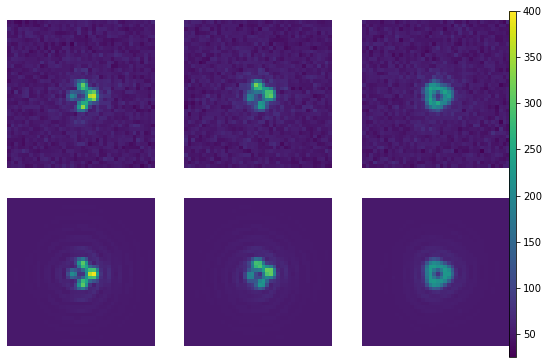

In [24]:
zdiv_mid_ind = int((zf-zi)/z_step//2)
ret_stack = yhat.detach()
fig, ax = plt.subplots(2,3,figsize=(9,6))
for ind in range(3):
    im = ax[0,ind].imshow(data_stack[...,zdiv_mid_ind-1,ind],vmin=v_min,vmax=v_max)
    ax[0,ind].set_axis_off()
    ax[1,ind].imshow(ret_stack[...,zdiv_mid_ind-1,ind],vmin=v_min,vmax=v_max)
    ax[1,ind].set_axis_off()
cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

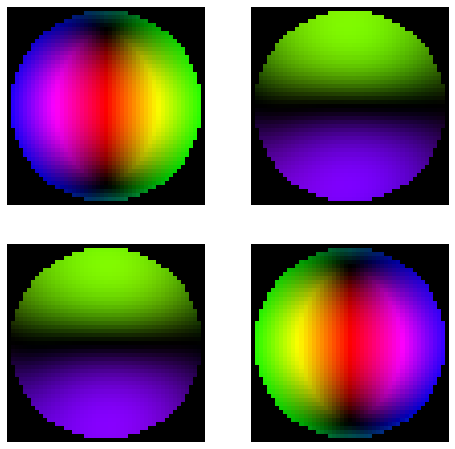

In [25]:
ret_pupil_params = get_pupils_param_dict(model_retrieved)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
abe.plot_pupil_field()

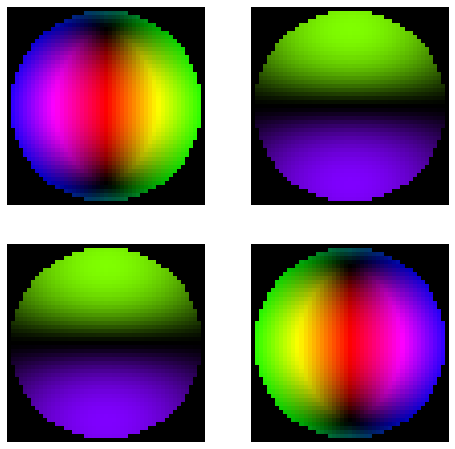

In [16]:
seo.plot_pupil_field()

## 3. No polarization diversity

In [131]:
params['qplate'] = {}
params['qplate']['q'] = 1/2
params['seo'] = {}
params['seo']['c'] = np.pi#1.24*np.pi

src = DipoleInterfaceSource(**params['pupil'],**params['source'])
# wdw = Qplate(**params['pupil'],**params['qplate'])
wdw = SEO(**params['pupil'],**params['seo'])
pupil_sequence = [src, wdw]
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
qwp = PDiversity_QWP(angle_list)
wollaston = PDiversity_LP(angle_list)
pdiv = PDiversity_Compound([wollaston])
# blurring = ExactBlurring(**params['blurring'],**params['pupil'])
psfs = PSFStack(pupil_sequence, zdiversity=zdiv)
psfs.compute_psf_stack(orientation=[0,0,1])

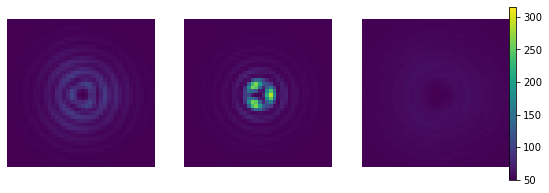

In [132]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=False)
v_max = np.max(data_stack)
v_min = np.min(data_stack)
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].imshow(data_stack[...,0],vmin=v_min,vmax=v_max)
im = axs[1].imshow(data_stack[...,zdiv_mid_ind],vmin=v_min,vmax=v_max)
axs[2].imshow(data_stack[...,-1],vmin=v_min,vmax=v_max)
for ax in axs.ravel():
    ax.set_axis_off()

cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

In [133]:
params['aberrations'] = {}
params['aberrations']['jmax_list'] = [15]*4+[15]

tsrc = torchDipoleInterfaceSource(**params['pupil'],**params['source'])
twdw = torchUnitaryAberrations(**params['pupil'], **params['aberrations'])
tpupil_sequence = [tsrc, twdw]
tzdiv = torchZDiversity(**params['zdiversity'], **params['pupil'])
# tpdiv = torchPDiversity_LP(angle_list)

model_retrieved = torchPSFStack(
                 data_stack.shape[0],
                 tpupil_sequence,
                 zdiversity=tzdiv
                 )

data_norm, data_bck = get_normNbck(data_stack)
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()
model_retrieved.set_scale_factor(data_norm/torch.sum(first_est))
model_retrieved.set_pb_bck(data_bck, opt_b=True)
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()

In [134]:
lr = 3e-2#3e-2
n_epochs = 300

loss_fn = nn.MSELoss(reduction='mean')#loss_loglikelihood#

optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
data = torch.from_numpy(data_stack).type(torch.float)

loss_evol =[]
for epoch in tqdm(range(n_epochs)):
    
    model_retrieved.train()
    yhat = model_retrieved()
    
    loss = loss_fn(yhat, data)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 300/300 [00:21<00:00, 13.68it/s]


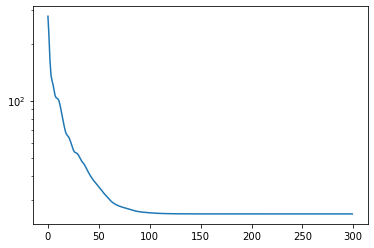

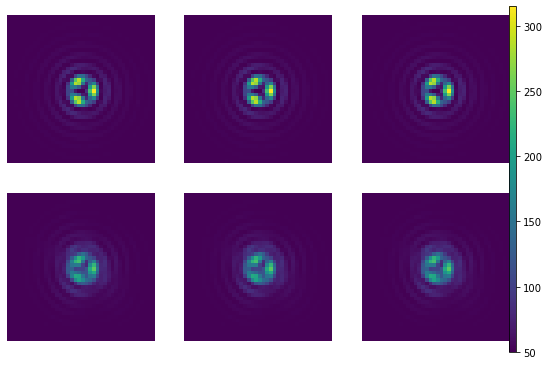

In [135]:
plt.plot(loss_evol)
plt.gca().set_yscale('log')

zdiv_mid_ind = int((zf-zi)/z_step//2)
ret_stack = yhat.detach()
fig, ax = plt.subplots(2,3,figsize=(9,6))
for ind in range(3):
    im = ax[0,ind].imshow(data_stack[...,zdiv_mid_ind-1],vmin=v_min,vmax=v_max)
    ax[0,ind].set_axis_off()
    ax[1,ind].imshow(ret_stack[...,zdiv_mid_ind-1],vmin=v_min,vmax=v_max)
    ax[1,ind].set_axis_off()
cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

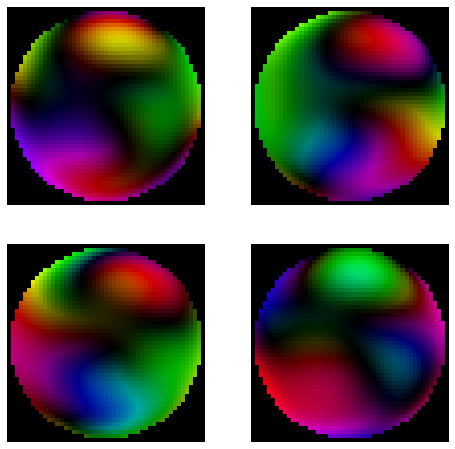

In [136]:
ret_pupil_params = get_pupils_param_dict(model_retrieved)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
abe.plot_pupil_field()

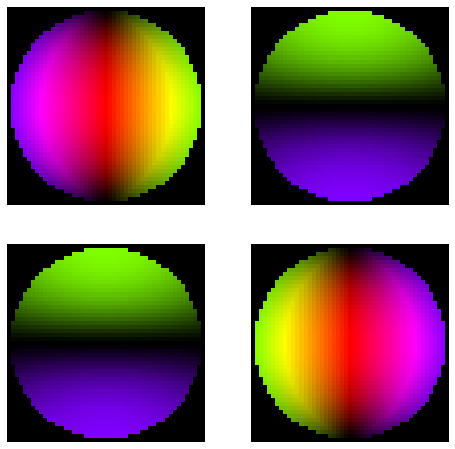

In [137]:
wdw.plot_pupil_field()

# Extra stuff

In [ ]:
import scipy.io as sio
import sys
import os

In [ ]:
mat_data = sio.loadmat(os.path.join('data','Rodrigo_14Jul2021_TIRF_Run1.mat'))

In [ ]:
zdiv_mid_ind = 6
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(mat_data['beads_rodrigo'][0,...,0,ind])
    axs[1,ind].imshow(mat_data['beads_rodrigo'][0,...,zdiv_mid_ind,ind])
    axs[2,ind].imshow(mat_data['beads_rodrigo'][0,...,-1,ind])
for ax in axs.ravel():
    ax.set_axis_off()

In [ ]:
exp_stack = 0.24*(mat_data['beads_rodrigo'][0]-100)

In [ ]:
get_normNbck(exp_stack)